In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime as dt
import scipy as sp

In [2]:
# create variables for the BTC and SPY tickers and dates (as strings) for the timeframe to examine
btc_ticker = 'BTC-USD'
spy_ticker = 'SPY'
start_date = '2020-01-01'
end_date = '2023-04-27'

In [3]:
# download the historical data using yfinance for BTC
btc_df = yf.download(btc_ticker, start=start_date, end=end_date)
btc_df.reset_index(inplace=True)
# create a column for the mean price for each day, this will be used as the purchase price
btc_df['Mean'] = (btc_df['Open'] + btc_df['Close']) / 2
# move the mean column
btc_df.insert(4, 'Mean', btc_df.pop('Mean'))
# round all the values to 2 decimals
btc_df = btc_df.round(2)

[*********************100%***********************]  1 of 1 completed


In [4]:
# download the historical data using yfinance for SPY
spy_df = yf.download(spy_ticker, start=start_date, end=end_date)
spy_df.reset_index(inplace=True)
# create a column for the mean price for each day, this will be used as the purchase price
spy_df['Mean'] = (spy_df['Open'] + spy_df['Close']) / 2
# move the mean column
spy_df.insert(4, 'Mean', spy_df.pop('Mean'))
# round all the values to 2 decimals
spy_df = spy_df.round(2)

[*********************100%***********************]  1 of 1 completed


In [5]:
# convert dates to datetime format
start_date = dt.strptime(start_date, '%Y-%m-%d')
end_date = dt.strptime(end_date, '%Y-%m-%d')

In [6]:
# create a function that calculated the weekly change in BTC and SPY
def calculate_weekly_change(btc_df, spy_df):
    '''
    This function calculated the weekly change in price
    of SPY and BTC and returns a new dataframe with
    columns for the change in BTC and SPY price with the
    week end date as the index

    Parameters
    ----------
    btc_df : BTC price ticker dataframe
    spy_df : SPY price ticker dataframe

    Returns
    -------
    weekly_change : New pandas dataframe as described above

    '''
    # Find the index of the first Monday in the BTC dataframe
    btc_start_idx = btc_df[btc_df['Date'].dt.weekday == 0].index[0]

    # Find the index of the first Monday in the SPY dataframe
    spy_start_idx = spy_df[spy_df['Date'].dt.weekday == 0].index[0]

    # Select only the rows from the first Monday onwards for both dataframes
    btc_df = btc_df.loc[btc_start_idx:]
    spy_df = spy_df.loc[spy_start_idx:]
    
    # group BTC data by week starting on Monday
    btc_weekly = btc_df.groupby(pd.Grouper(key='Date', freq='W-SUN')).agg({'Open': 'first', 'High': 'max', 'Low': 'min', 'Close': 'last'})
    btc_weekly['BTC_Percent_Change'] = round((btc_weekly['Close'] - btc_weekly['Open']) / btc_weekly['Open'] * 100, 2)

    # group SPY data by week starting on Monday
    spy_weekly = spy_df.groupby(pd.Grouper(key='Date', freq='W-SUN')).agg({'Open': 'first', 'High': 'max', 'Low': 'min', 'Close': 'last'})
    spy_weekly['SPY_Percent_Change'] = round((spy_weekly['Close'] - spy_weekly['Open']) / spy_weekly['Open'] * 100, 2)

    # merge the BTC and SPY weekly dataframes
    weekly_change = pd.merge(btc_weekly[['BTC_Percent_Change']], spy_weekly[['SPY_Percent_Change']], left_index=True, right_index=True)
    
    # rename index to week ending
    weekly_change.index.name = 'Week Ending'
    
    return weekly_change

In [7]:
# get the weekly change df
weekly_change = calculate_weekly_change(btc_df, spy_df)

# add year column to dataframe
weekly_change['Year'] = weekly_change.index.year

# Create a regression plot of SPY weekly change vs BTC weekly change for the entire timeframe

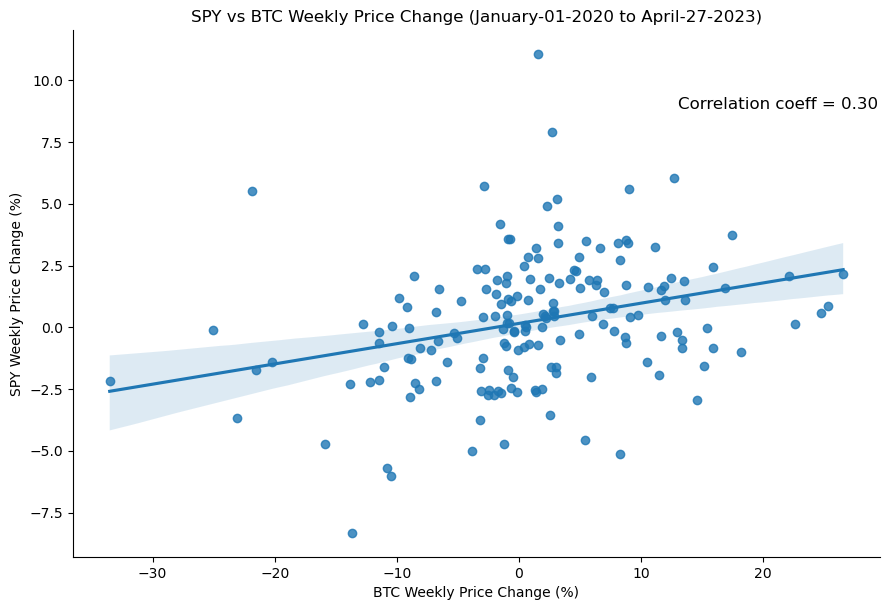

In [9]:
sns.lmplot(data=weekly_change, x='BTC_Percent_Change', y='SPY_Percent_Change', palette='Blues', height=6, aspect=1.5)

# Get correlation coefficient
corr_coef = weekly_change['BTC_Percent_Change'].corr(weekly_change['SPY_Percent_Change'])
text = f'Correlation coeff = {corr_coef:.2f}'
plt.annotate(text, xy=(0.75, 0.85), xycoords='axes fraction', fontsize=12)

# Set the x and y axis labels
plt.xlabel('BTC Weekly Price Change (%)')
plt.ylabel('SPY Weekly Price Change (%)')

# Set the title of the plot
plt.title(f'SPY vs BTC Weekly Price Change ({start_date:%B-%d-%Y} to {end_date:%B-%d-%Y})')

plt.show()

# Create facet grid for the weekly % change of SPY and BTC for each year

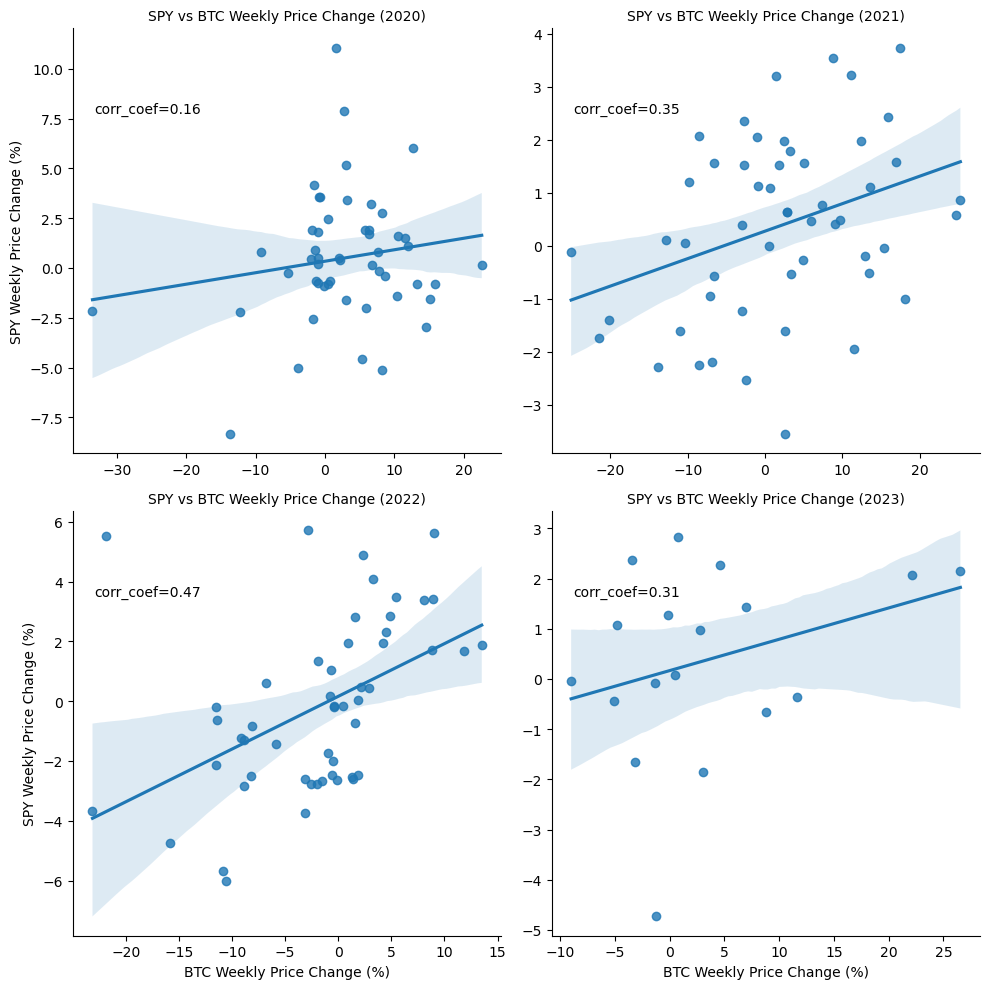

In [10]:
# define a function to calculate the correlation coefficient for each year
def annotate(data, **kws):
    r, p = sp.stats.pearsonr(data['BTC_Percent_Change'], data['SPY_Percent_Change'])
    ax = plt.gca()
    ax.text(.05, .8, f'corr_coef={r:.2f}' , transform=ax.transAxes)
    
# Create regression plots based on year
g = sns.lmplot(data=weekly_change, x='BTC_Percent_Change', y='SPY_Percent_Change', palette='Blues',
               col='Year', col_wrap=2, facet_kws=dict(sharex=False, sharey=False))

g.map_dataframe(annotate)

# Set the x and y axis labels
g.set_axis_labels('BTC Weekly Price Change (%)', 'SPY Weekly Price Change (%)')

# Set the title for each column
g.set_titles(col_template='SPY vs BTC Weekly Price Change ({col_name})')

plt.show()